<a href="https://colab.research.google.com/github/FernandaLimaFreire22/Prova1CEP/blob/main/Prova_de_CEP02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CEP com dataset Credit Card Fraud (Kaggle)
_______________________________________________________
### 0) Instalar pacotes necessários (se for Colab)

In [1]:
!pip -q install kaggle imbalanced-learn

### 1) Imports e configurações iniciais
__________________________________________________________

In [2]:
import os, json, glob, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,5)

OUTPUT_DIR = "/content/cep_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------------
# ========== PARÂMETROS ==========
# -------------------------------
# Se você já tem as credenciais configuradas no ambiente, comente as linhas abaixo.
KAGGLE_USERNAME = "fernandalimafreire2"   # substitua se quiser (mas você já usou esse)
KAGGLE_KEY = "f3db58b094db2c3244697e5d0c9ae37b"   # substitua se quiser

# Qual coluna usar como medida de processo?
MEASURE_COL = "Amount"   # escolha "Amount" ou outra coluna numérica
USE_LOG = False          # se True, usará log(Amount+1) para formar subgrupos
SUBGROUP_SIZE = 5        # tamanho do subgrupo (n) conforme enunciado da prova
MAX_OBS_TO_USE = 300     # quantas observações sequenciais usar do dataset (padrão 300 -> 60 subgrupos de 5)
# -------------------------------

print("Output_dir:", OUTPUT_DIR)
print("Parâmetros: MEASURE_COL=", MEASURE_COL, "USE_LOG=", USE_LOG, "SUBGROUP_SIZE=", SUBGROUP_SIZE, "MAX_OBS_TO_USE=", MAX_OBS_TO_USE)

Output_dir: /content/cep_outputs
Parâmetros: MEASURE_COL= Amount USE_LOG= False SUBGROUP_SIZE= 5 MAX_OBS_TO_USE= 300


### 2) Configurar Kaggle credentials (escreve /root/.kaggle/kaggle.json)
__________________________________________________________________________

In [3]:
os.makedirs('/root/.kaggle', exist_ok=True)
kaggle_json_path = '/root/.kaggle/kaggle.json'
with open(kaggle_json_path, 'w') as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod(kaggle_json_path, 0o600)

### 3) Baixar dataset via Kaggle e carregar CSV (creditcard.csv)
_____________________________________________________________________

In [4]:
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

print("\n📥 Baixando dataset do Kaggle (pode demorar alguns segundos)...")
!kaggle datasets download -d mlg-ulb/creditcardfraud -p {DATA_DIR} --unzip -q
csvs = glob.glob(os.path.join(DATA_DIR, "*.csv"))
if not csvs:
    raise FileNotFoundError("Nenhum CSV encontrado após download. Verifique credenciais e disponibilidade.")
csv_path = csvs[0]
print("Arquivo CSV encontrado:", csv_path)

df = pd.read_csv(csv_path)
print("Dimensão do dataset:", df.shape)
display(df.head())


📥 Baixando dataset do Kaggle (pode demorar alguns segundos)...
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
Arquivo CSV encontrado: /content/data/creditcard.csv
Dimensão do dataset: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 4) Preparar série de medidas (coluna Amount ou outra) e opcional log transform

In [5]:
if MEASURE_COL not in df.columns:
    raise ValueError(f"Coluna {MEASURE_COL} não encontrada no dataset. Colunas disponíveis: {list(df.columns)}")

series = df[MEASURE_COL].dropna().astype(float).values
if USE_LOG:
    series = np.log1p(series)  # log(Amount+1)

# usar apenas as primeiras MAX_OBS_TO_USE observações (para formar subgrupos)
values = series[:MAX_OBS_TO_USE]
m = len(values) // SUBGROUP_SIZE
remainder = len(values) % SUBGROUP_SIZE
if remainder:
    print(f"⚠️ Aviso: {remainder} observações serão descartadas para formar subgrupos completos.")
values_use = values[:m * SUBGROUP_SIZE]
subgroups = values_use.reshape(m, SUBGROUP_SIZE)
n_subgroups = subgroups.shape[0]
print(f"Formados {n_subgroups} subgrupos de tamanho {SUBGROUP_SIZE} (total de {m*SUBGROUP_SIZE} observações usadas).")

Formados 60 subgrupos de tamanho 5 (total de 300 observações usadas).


### 5) Cálculos por subgrupo: Xbar_i, R_i, std

In [6]:
sub_mean = subgroups.mean(axis=1)
sub_range = np.ptp(subgroups, axis=1)  # max-min
sub_std = subgroups.std(axis=1, ddof=1)

sub_df = pd.DataFrame({
    'subgroup': np.arange(1, n_subgroups+1),
    'mean': sub_mean,
    'range': sub_range,
    'std': sub_std
})

display(sub_df.head(10))

,subgroup,mean,range,std
0,1,144.892,375.97,142.266623
1,2,29.268,89.53,39.114295
2,3,45.118,113.70,47.324440
3,4,16.334,45.91,18.072455
4,5,58.344,230.82,97.922282
5,6,26.060,28.89,11.943632
6,7,7.156,15.51,5.934882
7,8,12.226,28.72,12.775857
8,9,14.426,27.54,10.197026
9,10,20.280,20.91,7.442523


### 6) Constantes A2, D3, D4 (tabela para n=2..10). Para n=5 usamos A2=0.577, D3=0, D4=2.114

In [7]:
constants = {
  2: {'A2':1.880, 'D3':0.000, 'D4':3.267},
  3: {'A2':1.023, 'D3':0.000, 'D4':2.574},
  4: {'A2':0.729, 'D3':0.000, 'D4':2.282},
  5: {'A2':0.577, 'D3':0.000, 'D4':2.114},
  6: {'A2':0.483, 'D3':0.076, 'D4':2.004},
  7: {'A2':0.419, 'D3':0.136, 'D4':1.924},
  8: {'A2':0.373, 'D3':0.184, 'D4':1.864},
  9: {'A2':0.337, 'D3':0.223, 'D4':1.816},
 10: {'A2':0.308, 'D3':0.256, 'D4':1.777}
}
n = SUBGROUP_SIZE
if n not in constants:
    raise ValueError(f"Constantes não definidas para n={n}. Ajuste SUBGROUP_SIZE ou acrescente constantes.")
A2 = constants[n]['A2']; D3 = constants[n]['D3']; D4 = constants[n]['D4']

### 7) Estatísticas gerais e limites

In [8]:
Xbar_bar = sub_df['mean'].mean()
R_bar = sub_df['range'].mean()
S_bar = sub_df['std'].mean()

UCL_Xbar = Xbar_bar + A2 * R_bar
LCL_Xbar = Xbar_bar - A2 * R_bar
UCL_R = D4 * R_bar
LCL_R = D3 * R_bar

print("\n📐 Estatísticas gerais:")
print(f"X̄-bar = {Xbar_bar:.6f}")
print(f"R̄     = {R_bar:.6f}")
print(f"S̄     = {S_bar:.6f}")
print(f"Limites X̄: LCL = {LCL_Xbar:.6f} | CL = {Xbar_bar:.6f} | UCL = {UCL_Xbar:.6f}")
print(f"Limites R : LCL = {LCL_R:.6f} | CL = {R_bar:.6f} | UCL = {UCL_R:.6f}")


📐 Estatísticas gerais:
X̄-bar = 85.554733
R̄     = 301.015833
S̄     = 130.855734
Limites X̄: LCL = -88.131402 | CL = 85.554733 | UCL = 259.240869
Limites R : LCL = 0.000000 | CL = 301.015833 | UCL = 636.347472


### 8) Detectar pontos fora de controle

In [9]:
sub_df['ooc_Xbar'] = (sub_df['mean'] < LCL_Xbar) | (sub_df['mean'] > UCL_Xbar)
sub_df['ooc_R'] = (sub_df['range'] < LCL_R) | (sub_df['range'] > UCL_R)
ooc_x_idx = sub_df.loc[sub_df['ooc_Xbar'], 'subgroup'].tolist()
ooc_r_idx = sub_df.loc[sub_df['ooc_R'], 'subgroup'].tolist()

print("\n🔎 Pontos fora de controle (X̄):", ooc_x_idx if ooc_x_idx else "Nenhum")
print("🔎 Pontos fora de controle (R) : ", ooc_r_idx if ooc_r_idx else "Nenhum")

# salvar sub_df
csv_out = os.path.join(OUTPUT_DIR, "subgroup_stats_creditcard_amount.csv")
sub_df.to_csv(csv_out, index=False)
print("Subgrupos salvos em:", csv_out)


🔎 Pontos fora de controle (X̄): [11, 18, 29, 33]
🔎 Pontos fora de controle (R) :  [11, 18, 29, 31, 33, 35, 49]
Subgrupos salvos em: /content/cep_outputs/subgroup_stats_creditcard_amount.csv


### 9) Plot Carta X̄

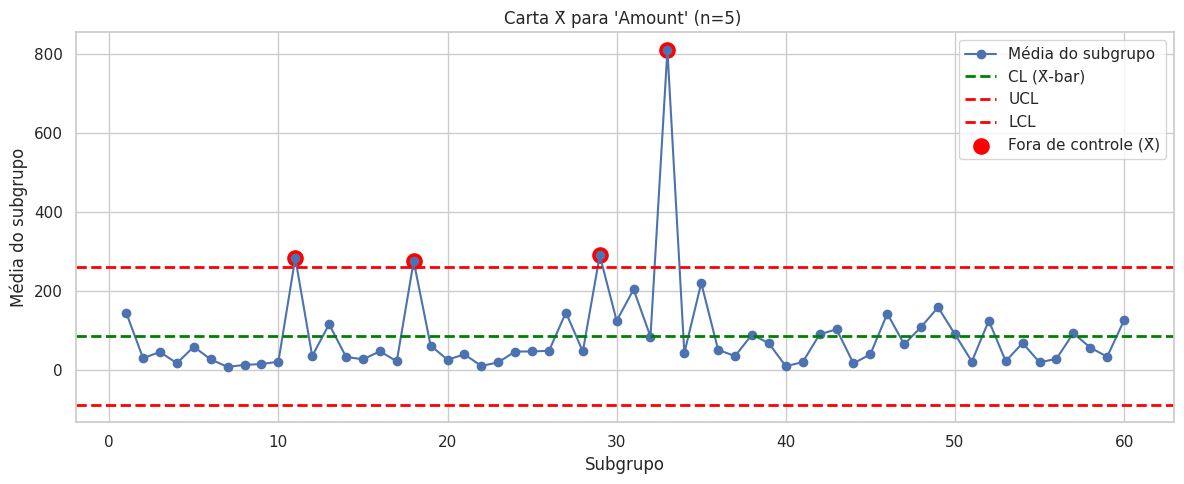

Gráfico X̄ salvo em: /content/cep_outputs/Xbar_chart_amount.png


In [10]:
plt.figure(figsize=(12,5))
plt.plot(sub_df['subgroup'], sub_df['mean'], marker='o', linestyle='-', label='Média do subgrupo')
plt.axhline(Xbar_bar, color='green', linestyle='--', linewidth=2, label='CL (X̄-bar)')
plt.axhline(UCL_Xbar, color='red', linestyle='--', linewidth=2, label='UCL')
plt.axhline(LCL_Xbar, color='red', linestyle='--', linewidth=2, label='LCL')
# opcional: linhas LIE/LSE (±1 vezes A2*R_bar/2) - se desejar, substitua por outra regra de zones
# destacar pontos fora de controle
if sub_df['ooc_Xbar'].any():
    plt.scatter(sub_df.loc[sub_df['ooc_Xbar'], 'subgroup'], sub_df.loc[sub_df['ooc_Xbar'], 'mean'],
                color='red', s=120, label='Fora de controle (X̄)')
plt.title(f"Carta X̄ para '{MEASURE_COL}' (n={n}) {'[log]' if USE_LOG else ''}")
plt.xlabel("Subgrupo")
plt.ylabel("Média do subgrupo")
plt.legend()
plt.grid(True)
plt.tight_layout()
xbar_png = os.path.join(OUTPUT_DIR, "Xbar_chart_amount.png")
plt.savefig(xbar_png, dpi=150)
plt.show()
print("Gráfico X̄ salvo em:", xbar_png)

### 10) Plot Carta R

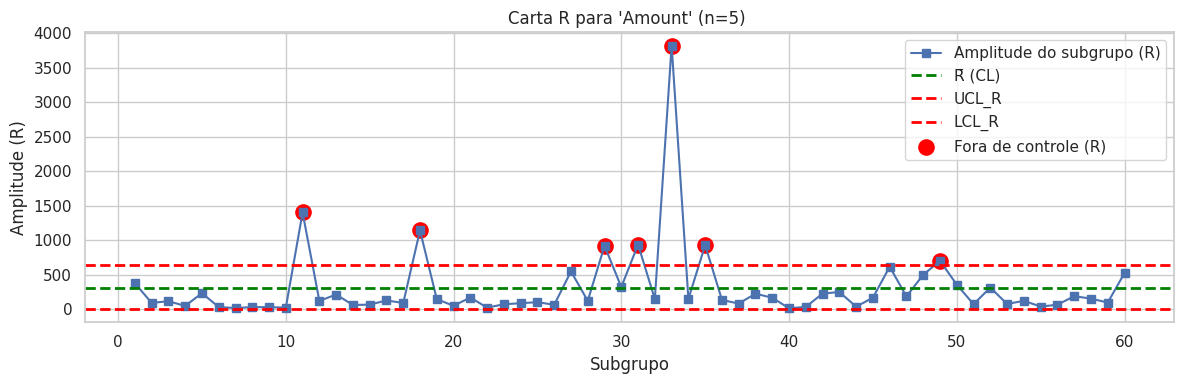

Gráfico R salvo em: /content/cep_outputs/R_chart_amount.png


In [11]:
plt.figure(figsize=(12,4))
plt.plot(sub_df['subgroup'], sub_df['range'], marker='s', linestyle='-', label='Amplitude do subgrupo (R)')
plt.axhline(R_bar, color='green', linestyle='--', linewidth=2, label='R̄ (CL)')
plt.axhline(UCL_R, color='red', linestyle='--', linewidth=2, label='UCL_R')
plt.axhline(LCL_R, color='red', linestyle='--', linewidth=2, label='LCL_R')
if sub_df['ooc_R'].any():
    plt.scatter(sub_df.loc[sub_df['ooc_R'], 'subgroup'], sub_df.loc[sub_df['ooc_R'], 'range'],
                color='red', s=120, label='Fora de controle (R)')
plt.title(f"Carta R para '{MEASURE_COL}' (n={n}) {'[log]' if USE_LOG else ''}")
plt.xlabel("Subgrupo")
plt.ylabel("Amplitude (R)")
plt.legend()
plt.grid(True)
plt.tight_layout()
r_png = os.path.join(OUTPUT_DIR, "R_chart_amount.png")
plt.savefig(r_png, dpi=150)
plt.show()
print("Gráfico R salvo em:", r_png)

### 11) Relatório resumido automático e recomendações

In [12]:
print("\n" + "="*60)
print("RELATÓRIO RESUMIDO - CEP (base: creditcard.csv - coluna: {})".format(MEASURE_COL))
print("="*60)
print(f"Número de subgrupos: {n_subgroups}")
print(f"Tamanho do subgrupo (n): {n}")
print(f"X̄-bar = {Xbar_bar:.6f}; R̄ = {R_bar:.6f}")
print(f"Limites X̄: LCL={LCL_Xbar:.6f}, CL={Xbar_bar:.6f}, UCL={UCL_Xbar:.6f}")
print(f"Limites R:  LCL={LCL_R:.6f}, CL={R_bar:.6f}, UCL={UCL_R:.6f}")
print("-"*60)
print("Pontos fora de controle (X̄):", ooc_x_idx if ooc_x_idx else "Nenhum")
print("Pontos fora de controle (R) : ", ooc_r_idx if ooc_r_idx else "Nenhum")
print("-"*60)

print("\nInterpretação e Recomendações:")
if (not ooc_x_idx) and (not ooc_r_idx):
    print("→ Processo aparenta estar sob controle estatístico no recorte analisado.")
else:
    print("→ Foram detectados pontos fora de controle. Recomendações iniciais:")
    if ooc_x_idx:
        print(f"   - Investigar subgrupos {ooc_x_idx}: verificar eventos, horários, lote, operações.")
    if ooc_r_idx:
        print(f"   - Investigar variabilidade nos subgrupos {ooc_r_idx}: checar estabilidade do equipamento.")
    print("   - Verificar calibração de instrumentos e outliers nos dados.")
print("\nObservação: 'Amount' é uma variável transacional e apresenta alta assimetria; interpretar limites com cautela. Pode ser interessante monitorar também log(Amount+1).")



RELATÓRIO RESUMIDO - CEP (base: creditcard.csv - coluna: Amount)
Número de subgrupos: 60
Tamanho do subgrupo (n): 5
X̄-bar = 85.554733; R̄ = 301.015833
Limites X̄: LCL=-88.131402, CL=85.554733, UCL=259.240869
Limites R:  LCL=0.000000, CL=301.015833, UCL=636.347472
------------------------------------------------------------
Pontos fora de controle (X̄): [11, 18, 29, 33]
Pontos fora de controle (R) :  [11, 18, 29, 31, 33, 35, 49]
------------------------------------------------------------

Interpretação e Recomendações:
→ Foram detectados pontos fora de controle. Recomendações iniciais:
   - Investigar subgrupos [11, 18, 29, 33]: verificar eventos, horários, lote, operações.
   - Investigar variabilidade nos subgrupos [11, 18, 29, 31, 33, 35, 49]: checar estabilidade do equipamento.
   - Verificar calibração de instrumentos e outliers nos dados.

Observação: 'Amount' é uma variável transacional e apresenta alta assimetria; interpretar limites com cautela. Pode ser interessante monitor

# TIRAR OS PONTOS FORA DE CONTROLE